# Comparing phone plans

We work as analysts for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

We are going to carry out a preliminary analysis of the plans based on a relatively small client selection. We'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Our job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

**The purpose of the project:**

To determine which prepaid plan brings in more revenue.

Another request from the commercial department is to check if clients from NY-NJ area bring more, equal or less revenue than clients from other regions.


## Initialization

First we will load libraries we might need, and limit our data to 3 decimals for clarity and focus. 

In [1]:
# Loading all the libraries
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
# pd.options.display.float_format = '{:.3f}'.format

## Load data

Now we will load the data files on the 500 Megaline clients:

In [2]:
# Load the data files into different DataFrames
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv') 
messages = pd.read_csv('/datasets/megaline_messages.csv') 
internet = pd.read_csv('/datasets/megaline_internet.csv') 

## Prepare the data

Next we will explore each one of the data tables, to get an initial understanding of the data. we will make necessary corrections to each table if necessary.

### Plans

In [3]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


Above we can see this table has 2 rows - one for each plan, specifying it's conditions. Datatypes look ok and there are no missing vallues. Let's take a look at the data itself:

In [4]:
# Print a sample of data (which is all the data) for plans
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Plans conditions look clear. We will study it in detail below (see section 1.4). 

#### Fix data

For now, no fixes seem needed.

#### Enrich data

Since Megaline policy is rounding up MB to GB (monthly) and charging by GB, we will add to 'mb_per_month_included' also 'gb_per_month_included' (dividing by 1024):

In [5]:
# adding a column with the gb_included_per_month: 
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


### Users

In [6]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Print a sample of data for users
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


We can see we have full data on all 500 clients, while churn date is relevan only for 34 of them, and the rest are still active clients at the end of 2018, when the data was taken. 

We will:
1. Check for duplicates (and if there are - remove them)
2. Change the data type of 'reg_date' and 'churn_date' into 'datetime'
3. Check how many cients in the data are in each prepaid plan
4. Add a column clasifying client if they are from NY-NJ area or not (following the request to check if there is a difference in revenue between this area and the other regions) 

#### Fix Data

In [8]:
# checking for duplicates: 
users.duplicated().sum()

0

In [9]:
# change the data type of 'reg_date' and 'churn_date' into 'datetime':
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [10]:
users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: int64

So our datatypes are ok now, and we see we have 339 clients on Surf and 161 clients on Ultimate. 

#### Enrich Data

In [11]:
# searching for the way NY-NJ area is written:
users['city'][users['city'].str.contains('NY-NJ')]

14     New York-Newark-Jersey City, NY-NJ-PA MSA
22     New York-Newark-Jersey City, NY-NJ-PA MSA
24     New York-Newark-Jersey City, NY-NJ-PA MSA
27     New York-Newark-Jersey City, NY-NJ-PA MSA
31     New York-Newark-Jersey City, NY-NJ-PA MSA
                         ...                    
469    New York-Newark-Jersey City, NY-NJ-PA MSA
482    New York-Newark-Jersey City, NY-NJ-PA MSA
494    New York-Newark-Jersey City, NY-NJ-PA MSA
495    New York-Newark-Jersey City, NY-NJ-PA MSA
498    New York-Newark-Jersey City, NY-NJ-PA MSA
Name: city, Length: 80, dtype: object

In [12]:
# creating a bool column for NY-NJ area: 
users['NY_NJ'] = users['city'].str.contains('NY-NJ')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null datetime64[ns]
NY_NJ         500 non-null bool
dtypes: bool(1), datetime64[ns](2), int64(2), object(4)
memory usage: 31.9+ KB


In [13]:
# checking how many NY-NJ users are in the dataset: 
users['NY_NJ'].value_counts()

False    420
True      80
Name: NY_NJ, dtype: int64

So we see we have 80 clients from NY-NJ area, and the rest 420 are from other regions. We will return to this point below, when we come to test statistical hypotheses 

### Calls

In [14]:
# Print the general/summary information about the calls' DataFrame
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Print a sample of data for calls
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


We can see we have full data on all 137,735 calls

We will:
1. Check for duplicates (and if there are - remove them)
2. Change the data type of 'call_date' into 'datetime'
3. round up the duration (following Megaline policy that each individual call is rounded up to the minute) 
4. Add a 'month' column (for easier analysis) 

#### Fix data

In [16]:
# checking for duplicates: 
calls.duplicated().sum()

0

In [17]:
# change the data type of 'call_date' into 'datetime':
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [18]:
# round up the duration (following Megaline policy) and check it worked: 
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


Now datatypes are ok, and the duration is according to the way Megaline calculates it.

#### Enrich data

In [19]:
# add a 'month' column and check it worked:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


Now we have the month of each call in a separate easy-to-use column. 

### Messages

In [20]:
# Print the general/summary information about the messages' DataFrame
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [21]:
# Print a sample of data for messages
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


We can see we have full data on all 76,051 messages.

We will:
1. Check for duplicates (and if there are - remove them)
2. Change the data type of 'message_date' into 'datetime'
3. Add a 'month' column (for easier analysis)
4. Rename 'id' column into 'message_id' (for clarity for later data aggregation, when individual messages will be counted)

#### Fix data

In [22]:
# checking for duplicates: 
messages.duplicated().sum()

0

In [23]:
# change the data type of 'message_date' into 'datetime':
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


Now datatypes are ok.

#### Enrich data

In [24]:
# add a 'month' column:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [25]:
# change 'id' column name into 'message_id' (for later data aggregation):
messages.rename(columns={'id': 'message_id'}, inplace=True)
messages.head()

,message_id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


Now we have the month of each message in a separate easy-to-use column, and all columns names are ready for analysis.  

### Internet

In [26]:
# Print the general/summary information about the internet DataFrame
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [27]:
# Print a sample of data for the internet traffic
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


We can see we have full data on all 104,825 internet sessions.

We will:
1. Check for duplicates (and if there are - remove them)
2. Change the data type of 'session_date' into 'datetime'
3. Add a 'month' column (for easier analysis)
4. Check the zero value we see in the mb_used column 

Unlike with call duration, here we will not round up yet, following Megaline policy: 
"For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes." So we will return to this issue soon, when we aggregate data per user. 

#### Fix data

In [28]:
# checking for duplicates: 
internet.duplicated().sum()

0

In [29]:
# change the data type of 'session_date' into 'datetime':
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


Now datatypes are ok.

#### Enrich data

In [30]:
# add a 'month' column:
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


Now we have the month of each internet session in a separate easy-to-use column.

#### Check zero value(s)

Since we see a zero value in the mb_used column, let's first check if there are more such cases:

In [31]:
# Check how many zero values are there in the mb_used column:
internet.query('mb_used == 0.00')  

,id,user_id,session_date,mb_used,month
1,1000_204,1000,2018-12-31,0.0,12
14,1001_26,1001,2018-09-17,0.0,9
16,1001_28,1001,2018-10-17,0.0,10
34,1001_54,1001,2018-09-02,0.0,9
43,1001_77,1001,2018-10-31,0.0,10
...,...,...,...,...,...
104797,1499_192,1499,2018-09-19,0.0,9
104804,1499_199,1499,2018-12-09,0.0,12
104816,1499_211,1499,2018-09-26,0.0,9
104817,1499_212,1499,2018-09-11,0.0,9


We have 13,747 cases of internet sessions that used zero MB. How can that be? probably these are sessions that started - to be registered - but ended immediately for some reason. In any case it is of no importance since later we will aggregate monthly usage. Obviously we can and we will remove these rows (so we should be left with 91,078 rows), but even if we wouldn't do it - such zero values will not impact the aggregated monthly usage, which will be our base for analysis. 

In [32]:
# removing the rows with internet sessions with zero mb_used:
internet = internet.query('mb_used != 0.00')
internet

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
5,1001_0,1001,2018-08-24,284.68,8
...,...,...,...,...,...
104819,1499_214,1499,2018-10-18,261.13,10
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9


As expected, 91,078 entries of internet sessions without the zero values. 

## Study plan conditions

Since for our analysis it is critical to understand how the plans work, how users are charged based on their plan subscription, we will now again print out the plan information to view their conditions once again.

In [33]:
# Re-print out the plan conditions 
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


So these are the conditions of each plan:


**Surf**
1. Monthly charge: 20 usd 
2. 500 monthly minutes, 50 texts, and 15 GB of data (gb is 1024 mb)
3. After exceeding the package limits:

    a. 1 minute: 3 cents.
    b. 1 text message: 3 cents.
    c. 1 GB of data: 10 usd. 
**Ultimate**
1. Monthly charge: 70 usd
2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:

    a. 1 minute: 1 cent.
    b. 1 text message: 1 cent.
    c. 1 GB of data: 7 usd. 
    
As mentioned above - for calls each call duration is rounded up to minutes (was done above), and for web trafic the monthly mb total is rounded up to gb (will be done below). 

## Aggregate data per user

Now we are ready to aggregate data per user per month in order to have just one record per user per month (which is the paymnet time unit). This will form the base for the further analysis. 

### Calls 

In [34]:
# The number of calls made and the amount of minutes spent
    # by each user per month:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], 
                                values='duration', aggfunc=['count', 'sum'])
calls_pivot.head()

count      sum
              duration duration
user_id month                  
1000    12          16      124
1001    8           27      182
        9           49      315
        10          65      393
        11          64      426

### Messages 

In [35]:
# The number of messages sent by each user per month. Save the result.
messages_pivot = messages.pivot_table(index=['user_id', 'month'], 
                                      values='message_id', aggfunc='count')
messages_pivot.head()

message_id
user_id month            
1000    12             11
1001    8              30
        9              44
        10             53
        11             36

### Internet 

In [36]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_pivot = internet.pivot_table(index=['user_id', 'month'], 
                                      values='mb_used', aggfunc='sum')
internet_pivot.head()

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30

### Calls + Messages + Internet 
We will now put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month. 
Then we will rename columns for simplicity and clarity, and add GB charged (according to Megaline policy of rounding up monthly web usage).

In [37]:
# Merge the data for calls, minutes, messages, internet - based on user_id and month:
cm_pivot = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
user_pivot = cm_pivot.merge(internet_pivot, on=['user_id', 'month'], how='outer').reset_index() 
user_pivot

,user_id,month,"(count, duration)","(sum, duration)",message_id,mb_used
0,1000,12,16.0,124.0,11.0,1901.47
1,1001,8,27.0,182.0,30.0,6919.15
2,1001,9,49.0,315.0,44.0,13314.82
3,1001,10,65.0,393.0,53.0,22330.49
4,1001,11,64.0,426.0,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13039.91
2289,1361,5,NaN,NaN,2.0,1519.69
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,233.17


Since we see null values, that appear in all cases in which a user, in a specific month, used only 1 or 2 out of the 3 services (calls, messages, internet) - we will fill them with 0 (zero usage), in order not to distort later analysis. 

In [38]:
# filling null values with 0: 
user_pivot = user_pivot.fillna(0)
user_pivot

,user_id,month,"(count, duration)","(sum, duration)",message_id,mb_used
0,1000,12,16.0,124.0,11.0,1901.47
1,1001,8,27.0,182.0,30.0,6919.15
2,1001,9,49.0,315.0,44.0,13314.82
3,1001,10,65.0,393.0,53.0,22330.49
4,1001,11,64.0,426.0,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91
2289,1361,5,0.0,0.0,2.0,1519.69
2290,1482,10,0.0,0.0,2.0,0.00
2291,1108,12,0.0,0.0,0.0,233.17


In [39]:
# Cheking exact columns names (before renaming for simplicity): 
user_pivot.columns

Index([            'user_id',               'month', ('count', 'duration'),
         ('sum', 'duration'),          'message_id',             'mb_used'],
      dtype='object')

In [40]:
# renaming columns names for simplicity: 
user_pivot.rename(columns={('count', 'duration'): 'calls', ('sum', 'duration'): 'minutes',
                          'message_id': 'messages'}, inplace=True)
user_pivot

,user_id,month,calls,minutes,messages,mb_used
0,1000,12,16.0,124.0,11.0,1901.47
1,1001,8,27.0,182.0,30.0,6919.15
2,1001,9,49.0,315.0,44.0,13314.82
3,1001,10,65.0,393.0,53.0,22330.49
4,1001,11,64.0,426.0,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91
2289,1361,5,0.0,0.0,2.0,1519.69
2290,1482,10,0.0,0.0,2.0,0.00
2291,1108,12,0.0,0.0,0.0,233.17


Before we enrich this aggregated user_pivot table - we will check that data was not lost, and all the telecom usage that was documented in the original data files - is here in our user_pivot table. 

In [41]:
# compare total numbers of calls, duration, messages and web usage:
print('The original total number of calls was', calls['id'].count(),
      ', and in user_pivot we have', user_pivot['calls'].sum())
print('The original total rounded duration was', calls['duration'].sum(),
      'minutes, and in user_pivot we have', user_pivot['minutes'].sum())
print('The original total number of messages was', messages['message_id'].count(),
      ', and in user_pivot we have', user_pivot['messages'].sum())
print('The original total internet usage was', internet['mb_used'].sum(),
      ' MB, and in user_pivot we have', user_pivot['mb_used'].sum())

The original total number of calls was 137735 , and in user_pivot we have 137735.0
The original total rounded duration was 984347 minutes, and in user_pivot we have 984347.0
The original total number of messages was 76051 , and in user_pivot we have 76051.0
The original total internet usage was 38440763.71  MB, and in user_pivot we have 38440763.71


All the data is here, nothing lost, we can continue to enrich our aggregated user-month usage table: 

In [42]:
# add a column with the GB_charged, according to Megaline policy: 
user_pivot['gb_charged'] = user_pivot['mb_used'] / 1024
user_pivot['gb_charged'] = np.ceil(user_pivot['gb_charged']).astype('int')
user_pivot

,user_id,month,calls,minutes,messages,mb_used,gb_charged
0,1000,12,16.0,124.0,11.0,1901.47,2
1,1001,8,27.0,182.0,30.0,6919.15,7
2,1001,9,49.0,315.0,44.0,13314.82,14
3,1001,10,65.0,393.0,53.0,22330.49,22
4,1001,11,64.0,426.0,36.0,18504.30,19
...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91,13
2289,1361,5,0.0,0.0,2.0,1519.69,2
2290,1482,10,0.0,0.0,2.0,0.00,0
2291,1108,12,0.0,0.0,0.0,233.17,1


### Adding plan and region information

In [43]:
# Add the plan and region information
user_plan = users[['user_id', 'plan', 'NY_NJ']]
user_pivot = user_pivot.merge(user_plan, on='user_id', how='left')
user_pivot

,user_id,month,calls,minutes,messages,mb_used,gb_charged,plan,NY_NJ
0,1000,12,16.0,124.0,11.0,1901.47,2,ultimate,False
1,1001,8,27.0,182.0,30.0,6919.15,7,surf,False
2,1001,9,49.0,315.0,44.0,13314.82,14,surf,False
3,1001,10,65.0,393.0,53.0,22330.49,22,surf,False
4,1001,11,64.0,426.0,36.0,18504.30,19,surf,False
...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91,13,surf,False
2289,1361,5,0.0,0.0,2.0,1519.69,2,surf,False
2290,1482,10,0.0,0.0,2.0,0.00,0,ultimate,True
2291,1108,12,0.0,0.0,0.0,233.17,1,ultimate,False


In [45]:
# checking how many entries (paid months) there are from each region option:  
user_pivot['NY_NJ'].value_counts()

False    1916
True      377
Name: NY_NJ, dtype: int64

### Calculating monthly revenues 

We will now calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan).

In [46]:
# Calculate the monthly revenues for each user
def monthly_revenue(user_pivot):
    
    if user_pivot['plan'] == 'surf':
        plan = plans.query('plan_name == "surf"')
    if user_pivot['plan'] == 'ultimate':
        plan = plans.query('plan_name == "ultimate"')
        
    user_pivot['revenue'] = plan['usd_monthly_pay'].values[0]
    if user_pivot['minutes'] > plan['minutes_included'].values[0]:
        user_pivot['revenue'] += (
            (plan['usd_per_minute'].values[0])*
            (user_pivot['minutes'] - plan['minutes_included'].values[0]))
    if user_pivot['messages'] > plan['messages_included'].values[0]:
        user_pivot['revenue'] += (
            (plan['usd_per_message'].values[0])*
            (user_pivot['messages'] - plan['messages_included'].values[0]))
    if user_pivot['gb_charged'] > plan['gb_per_month_included'].values[0]:
        user_pivot['revenue'] += (
            (plan['usd_per_gb'].values[0])*
            (user_pivot['gb_charged'] - plan['gb_per_month_included'].values[0]))
        
    return user_pivot['revenue']

user_pivot['revenue'] = user_pivot.apply(monthly_revenue, axis=1)            
user_pivot  

,user_id,month,calls,minutes,messages,mb_used,gb_charged,plan,NY_NJ,revenue
0,1000,12,16.0,124.0,11.0,1901.47,2,ultimate,False,70.00
1,1001,8,27.0,182.0,30.0,6919.15,7,surf,False,20.00
2,1001,9,49.0,315.0,44.0,13314.82,14,surf,False,20.00
3,1001,10,65.0,393.0,53.0,22330.49,22,surf,False,90.09
4,1001,11,64.0,426.0,36.0,18504.30,19,surf,False,60.00
...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91,13,surf,False,20.33
2289,1361,5,0.0,0.0,2.0,1519.69,2,surf,False,20.00
2290,1482,10,0.0,0.0,2.0,0.00,0,ultimate,True,70.00
2291,1108,12,0.0,0.0,0.0,233.17,1,ultimate,False,70.00


In [ ]:
def monthly_revenue_review(row):

    money = 0
    
    plan = row['plan']
    calls_sum = row['calls']
    messages_count = row['messages']
    gb_sum_internet = row['gb_charged']
    
    # Here we calculate difference between real usage and included in the plan
    difference_calls = calls_sum - float(plans[plans['plan_name'] == plan]['minutes_included'])
    difference_messages = messages_count - float(plans[plans['plan_name'] == plan]['messages_included'])
    difference_internet = gb_sum_internet - float(plans[plans['plan_name'] == plan]['gb_per_month_included'])
    
    
    # If the user went beyond the plan, calculate additional fee
    if (difference_calls > 0):
        money += difference_calls * float(plans[plans['plan_name'] == plan]['usd_per_minute'])
    if difference_messages > 0:
        money += difference_messages * float(plans[plans['plan_name'] == plan]['usd_per_message'])
    if difference_internet > 0:
        money += difference_internet * float(plans[plans['plan_name'] == plan]['usd_per_gb'])
    
    # add monthly fees
    money += float(plans[plans['plan_name'] == plan]['usd_monthly_pay'])
    
    return money


## Study user behaviour

We will now analyse user behavior and calculate some descriptive statistics. Given that the main task is to compare the plans and decide on which one is more profitable, the main aim of this section is to compare user behavior between the two plans.


### Calls

#### Average duration of an individual call 

In [47]:
# Calaulate average duration of calls per each plan per each distinct month:
user_pivot['av_call'] = user_pivot['minutes'] / user_pivot['calls'] 
user_pivot

,user_id,month,calls,minutes,messages,mb_used,gb_charged,plan,NY_NJ,revenue,av_call
0,1000,12,16.0,124.0,11.0,1901.47,2,ultimate,False,70.00,7.750000
1,1001,8,27.0,182.0,30.0,6919.15,7,surf,False,20.00,6.740741
2,1001,9,49.0,315.0,44.0,13314.82,14,surf,False,20.00,6.428571
3,1001,10,65.0,393.0,53.0,22330.49,22,surf,False,90.09,6.046154
4,1001,11,64.0,426.0,36.0,18504.30,19,surf,False,60.00,6.656250
...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91,13,surf,False,20.33,NaN
2289,1361,5,0.0,0.0,2.0,1519.69,2,surf,False,20.00,NaN
2290,1482,10,0.0,0.0,2.0,0.00,0,ultimate,True,70.00,NaN
2291,1108,12,0.0,0.0,0.0,233.17,1,ultimate,False,70.00,NaN


In [48]:
# fill the NaN average values with 0:
user_pivot = user_pivot.fillna(0)

In [49]:
# Compare average duration of call (per month) between the plans  
comp_av_call = user_pivot.pivot_table(index='month', columns='plan', values='av_call', aggfunc='mean')
comp_av_call

plan,surf,ultimate
month,,
1,6.642857,6.201915
2,6.814628,6.053403
3,7.199957,6.393757
4,7.040349,7.215266
5,6.996065,7.121973
6,7.141114,6.807941
7,6.969665,7.324718
8,6.995927,7.018966
9,7.017420,7.117788


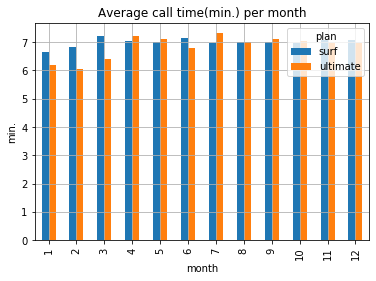

In [50]:
# a bar plot to visualize the average call time:
comp_av_call.plot(kind='bar', grid=True)
plt.title('Average call time(min.) per month')
plt.ylabel('min.')
plt.show;

**Conclusions:**

Generally speaking, average call duration (after rounding up each call) is similar between the plans, and is between 6 - 7.3 minutes per call. 

In some months (Jan-Mar) we can see Surf users with a bit higher average call duration than Ultimate, and in some others ( April, Jul) Ultimate users have a bit higher average call duration then Surf (but to a much smaller extnt). But the overall general picture is similar user behavior. 

#### Monthly minutes 

In [51]:
# stats for monthly minutes per plan - first Surf:
user_pivot.query('plan == "surf"')['minutes'].describe()

count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: minutes, dtype: float64

In [52]:
# stats for monthly minutes per plan - now Ultimate:
user_pivot.query('plan == "ultimate"')['minutes'].describe() 

count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: minutes, dtype: float64

When we check the monthly minutes (which is the relevant number for payment) - we see **very close means**: 428.75 for Surf, and 430.45 for Ultimate. Standard deviations are also similar (234.45 vs. 240.51). **Medians are also similar**: 425 for Surf, and 424 for Ultimate. The whole IQR is generally speaking close between the plans, with slight higher numbers in Surf (272-576) vs. Ultimate (260-565). The max monthly minutes of Surf (1510) is also higher than Ultimate (1369).

Thinking about the plans conditions: it is noteworthy that no client was even close to reach the minutes included in Ultimate (3000), while for Surf the minutes included (500) are somewhere in the middle of third quartile of paid months, meaning way more than a qarter of the Surf months had extra payment for minutes. 

Remembering we have 1573 Surf months and only 720 Ultimate months in our minutes data, We will now visualise the distributions of monthly minutes in each plan:  

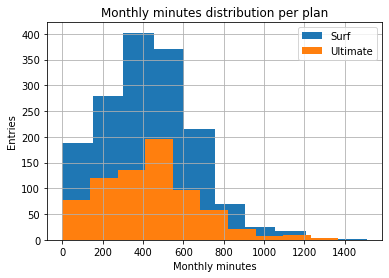

In [53]:
# a histogram of monthly minutes distributions of both plans: 
user_pivot.query('plan == "surf"')['minutes'].hist(grid=True)
user_pivot.query('plan == "ultimate"')['minutes'].hist()
plt.title('Monthly minutes distribution per plan')
plt.xlabel('Monthly minutes')
plt.ylabel('Entries')
plt.legend(['Surf', 'Ultimate'])
plt.show;

Blue is Surf (1573 entries) and orange is Ultimate (720 entries). While the general distribution seems similar (as the numbers above suggested) - we can see here that Surf has highest frequesncy months with ~300-450 monthly calls, and ~450-600 is still very high but a little lower, while Ultimate has it's highest frequency with ~450-550 monthly calls, and the ~300-450 calls has much lower amount of months. 

Still, for our comparisment the similarity seems for now more powerfull than the differences. We will compare again mean and variance - which are the most important for statistical comparisment:

In [54]:
# Compare the mean and the variance of the monthly call duration
comp_min_stats = user_pivot.pivot_table(index='plan', values='minutes', aggfunc=['mean', 'var'])
comp_min_stats

,mean,var
,minutes,minutes
plan,,
surf,428.749523,54968.279461
ultimate,430.450000,57844.464812


Both mean and variance of monthly minutes are clearly similar between the plans. Let's visualize it in a boxplot: 

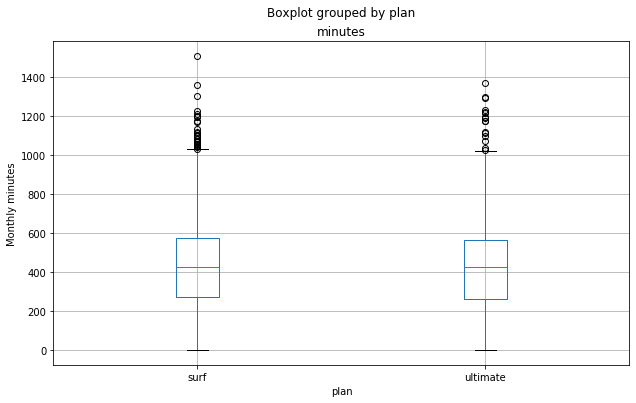

In [59]:
# Plot a boxplot to visualize the distribution of the monthly call duration
fig, ax = plt.subplots(figsize=(10,6))    
user_pivot.boxplot('minutes', by='plan', ax = ax)
plt.ylabel('Monthly minutes')
plt.show()  

The similarity of the whole IQR between the plans is shown clearly in the boxplot.


**General Conclusion:**

User behavior about calls is similar between the two plans. 

### Messages

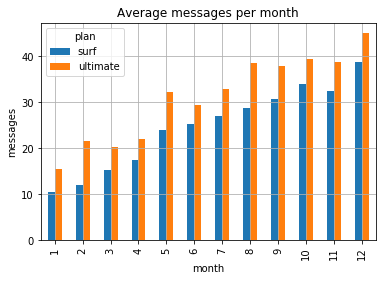

In [60]:
# Compare the number of messages users of each plan tend to send each month
user_pivot.pivot_table(index='month', columns='plan', values='messages',
                       aggfunc='mean').plot(kind='bar', grid=True)
plt.title('Average messages per month')
plt.ylabel('messages')
plt.show;

Here the picture seems more diversed: in almost all months Ultimate clients tend to send more messages than Surf clients. In some months (e.g. Feb, May and more) we see what seems like a meaningful difference. Let's check and compare the numbers:  

In [61]:
# stats for monthly messages per plan - first Surf:
user_pivot.query('plan == "surf"')['messages'].describe()

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: messages, dtype: float64

In [62]:
# stats for monthly messages per plan - now Ultimate:
user_pivot.query('plan == "ultimate"')['messages'].describe()

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: messages, dtype: float64

Ultimate have higher numbers for almost all stats: mean 37.55 messages (Surf 31.16), median 30 (Surf 24), IQR 7-61 (Surf 3-47). Standard deviation is similar (~33-34 both plans). Max monthly messages of Surf (266) is higher than Ultimate (166).

Payment wise - again no Ultimate user is even close to reach the monthly messages included (1000), while almost a quarter of Surf paid months had extra payment (above 50 messages). 

Remembering that Surf has here (again) 1573 entries and Ultimae only 720 - let's visualize the monthly messages distributions in each plan with a histograms graph: 

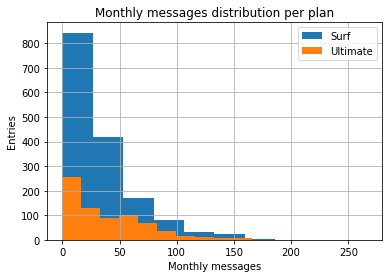

In [63]:
# a histogram of monthly messages distributions of both plans: 
user_pivot.query('plan == "surf"')['messages'].hist(grid=True)
user_pivot.query('plan == "ultimate"')['messages'].hist()
plt.title('Monthly messages distribution per plan')
plt.xlabel('Monthly messages')
plt.ylabel('Entries')
plt.legend(['Surf', 'Ultimate'])
plt.show;

The comparisment shows clearly how in Surf - unlike Ultimate - the lower numbers of messages (0-50) have picks of large amounts of entries (more than 1200 out of all 1573), while in Ultimate the amount of entries with higher numbers of messages are more substantial, and the histogram is more "shallow". That fits the higher monthly messages stats of Ultimate we saw above.

We will now summerize the comparisment of mean and variance of monthly messages between the plans: 

In [64]:
# Compare the mean and the variance of the monthly messages
comp_mes_stats = user_pivot.pivot_table(index='plan', values='messages', aggfunc=['mean', 'var'])
comp_mes_stats

,mean,var
,messages,messages
plan,,
surf,31.159568,1126.724522
ultimate,37.551389,1208.756744


Note that the Ultimate mean monthly messages number is more than 20% higher than that of Surf. Variance is similar as mentioned above. Let's visualize the distribution with a boxplot:  

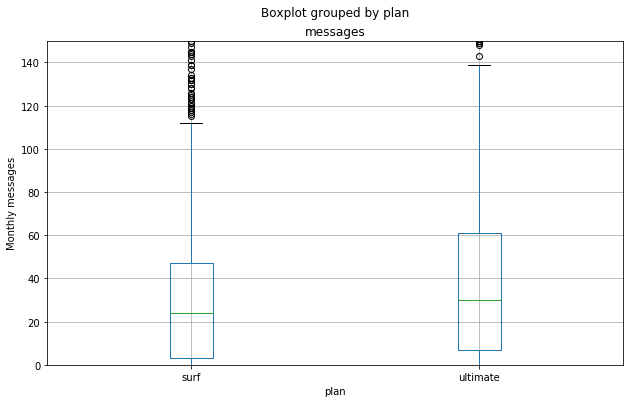

In [67]:
# Plot a boxplot to visualize the distribution of the monthly messages
fig, ax = plt.subplots(figsize=(10,6))    
user_pivot.boxplot('messages', by='plan', ax = ax)
plt.ylabel('Monthly messages')
plt.ylim(0, 150)
plt.show()  

**General conclusion** 

Ultimate users tend to send more text messages per month (mean ~15% more) than Surf users.  

### Internet

Since we are comparing now user behavior - we will use here 'mb_used' and not 'gb_charged' (later we will compare revenue). 

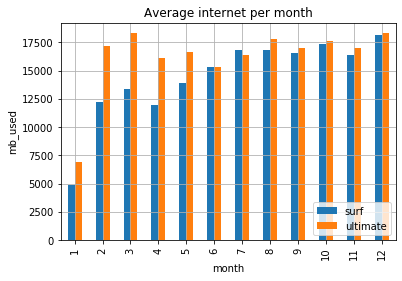

In [69]:
# Compare the amount of internet traffic consumed by users per plan per month
user_pivot.pivot_table(index='month', columns='plan', values='mb_used',
                       aggfunc='mean').plot(kind='bar', grid=True)
plt.title('Average internet per month')
plt.ylabel('mb_used')
plt.legend(loc = 'lower right')
plt.show;

We see here a mixed picture - some months are very similar between plans (Jun-Dec), while Jan-May show consistent higher internet consumption of Ultimate users compared to Surf users. Let's check the stats: 

In [70]:
# stats for monthly internet consumption - first Surf:
user_pivot.query('plan == "surf"')['mb_used'].describe()

count     1573.000000
mean     16558.283490
std       8013.513327
min          0.000000
25%      11986.520000
50%      16829.310000
75%      20999.610000
max      70931.590000
Name: mb_used, dtype: float64

In [71]:
# stats for monthly internet consumption - now Ultimate:
user_pivot.query('plan == "ultimate"')['mb_used'].describe()

count      720.000000
mean     17214.699694
std       7851.897435
min          0.000000
25%      12666.955000
50%      16858.340000
75%      21014.527500
max      46595.330000
Name: mb_used, dtype: float64

Generally speaking - we see similarity between the plans on all 3 quartiles, and the difference in mean seems not very meaningful. Standard deviation is also similar (8013.51 for Surf, 7851.9 for Ultimate). 
For payment - the difference is there: here for the first time we find some Ultimate paid months with extra payment (above 30 GB) - but far less than quarter of the paid months (3rd quartile only ~21 GB), while more than Half(!) of all Surf paid months had extra payment (above 15GB, the median paid for 17GB).

Remembering that Surf has here (again) 1573 entries and Ultimae only 720 - let's visualize the monthly internet distributions in each plan with a histograms graph: 

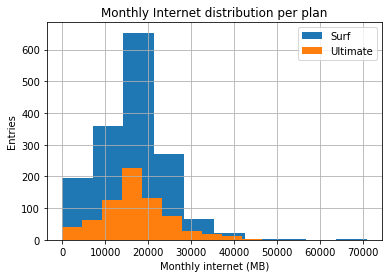

In [72]:
# a histogram of monthly internet distributions of both plans: 
user_pivot.query('plan == "surf"')['mb_used'].hist(grid=True)
user_pivot.query('plan == "ultimate"')['mb_used'].hist()
plt.title('Monthly Internet distribution per plan')
plt.xlabel('Monthly internet (MB)')
plt.ylabel('Entries')
plt.legend(['Surf', 'Ultimate'])
plt.show;

The similarity in distribution identified above - seems clear also in the histograms graph.

Staying for now with usage comparismant: let's concentrate on the comparisment of mean and variance of 'mb_used':

In [73]:
# Compare the mean and the variance of the monthly internet
comp_int_stats = user_pivot.pivot_table(index='plan', values='mb_used', aggfunc=['mean', 'var'])
comp_int_stats

,mean,var
,mb_used,mb_used
plan,,
surf,16558.283490,6.421640e+07
ultimate,17214.699694,6.165229e+07


The mean internet monthly usage of Ultimate users is a slightly higher than that of Surf users (~4% more), with similar variance. Let's visualize once again the distributions with a boxplot:   

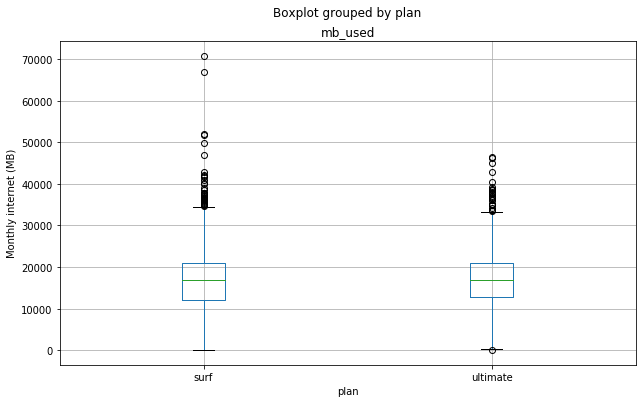

In [74]:
# Plot a boxplot to visualize the distribution of the monthly internet
fig, ax = plt.subplots(figsize=(10,6))    
user_pivot.boxplot('mb_used', by='plan', ax = ax)
plt.ylabel('Monthly internet (MB)')
plt.show()  

**General Conclusion** 

Ultimate and Surf users tend to consume the internet traffic similarly. No meaningful difference in user behavior is identified. 

## Revenue

After studying the user behaviour - we reach the main question : comparing the revenue between the plans.

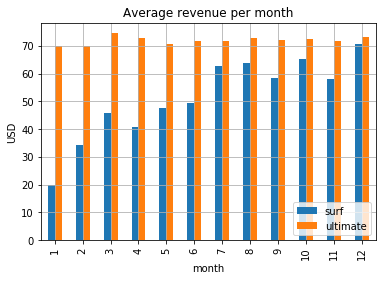

In [76]:
# Compare the revenue users of each plan tend to pay each month
user_pivot.pivot_table(index='month', columns='plan', values='revenue',
                       aggfunc='mean').plot(kind='bar', grid=True)
plt.title('Average revenue per month')
plt.ylabel('USD')
plt.legend(loc = 'lower right')
plt.show;

We can see a **clear and consistent higher average monthly revenue from Ultimate plan users** - stronger in Jan-Jun ( around twice as high in the first year quarter, Jan-Mar), but existing in all months in this level or another. 

We can see there is large diversity in the Surf average monthly revenues (20-70 USD), and almost uniformity in the Ultimate revenues (at or a bit above 70 USD), matching the picture we saw above about extra payments exixsitng or not.

Let's check the stats of all data revenues:  

In [77]:
# stats of monthly revenue per plan - first Surf: 
user_pivot.query('plan == "surf"')['revenue'].describe()

count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: revenue, dtype: float64

In [78]:
# stats of monthly revenue per plan - now Ultimate: 
user_pivot.query('plan == "ultimate"')['revenue'].describe()

count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: revenue, dtype: float64

We can see that while almost all Ultimate users pay each month the base monthly 70 USD, with relatively little impact of the extra (a small group, only on internet, as we saw above), and a mean of 72.3 USD with small std of 11.4 - the picture for Surf is totally different: 
large diversity, std 5 times bigger (!) than in Ultimate, IQR ranging 20-80 USD (while it's all 70 USD for Ultimate), and also the max payment (590 USD) is more than 3 times bigger than the max of Ultimate (182 USD). 

Remembering that Surf has here 1573 entries and Ultimae only 720 - let's visualize the monthly internet distributions in each plan with a histograms graph: 

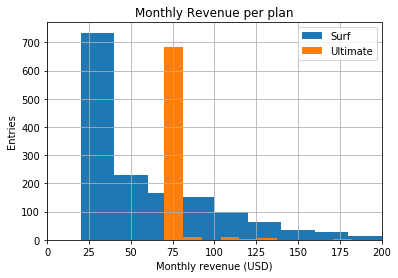

In [79]:
# a histogram of monthly revenue distributions of both plans: 
user_pivot.query('plan == "surf"')['revenue'].hist(bins=(
    0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 600), grid=True)
user_pivot.query('plan == "ultimate"')['revenue'].hist()
plt.title('Monthly Revenue per plan')
plt.xlabel('Monthly revenue (USD)')
plt.ylabel('Entries')
plt.legend(['Surf', 'Ultimate'])
plt.xlim(0, 200)
plt.show;

The huge difference in distributions, that we identified above, is very clearly seen in the compared histograms - almost all Ultimate entries are around 70 USD, while Surf is very diversed with about half of paid months not passing 40 USD, and another ~15% below 60 USD. 

Let's focus next on comparing the statistical mean and variance:  

In [80]:
# Compare the mean and the variance of the monthly revenue
comp_rev_stats = user_pivot.pivot_table(index='plan', values='revenue', aggfunc=['mean', 'var'])
comp_rev_stats

,mean,var
,revenue,revenue
plan,,
surf,60.706408,3067.835152
ultimate,72.313889,129.848486


We can see that Ultimate mean monthly revenue (72.31 USD) is almost 20% higher than that of Surf (60.71 USD), we will soon test the relevant statistiacal hypothesis. We note the difference in variance between the plans is huge (3067.84 vs. 129.85). Let's visualize the monthly revenues distributions of each plan:  

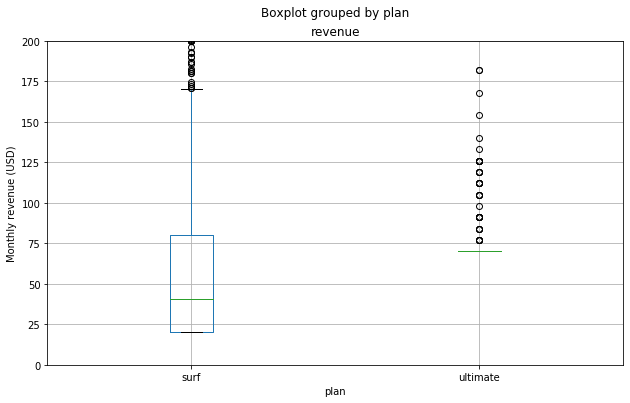

In [81]:
# Plot a boxplot to visualize the distribution of the monthly revenue (we will limit the graph to 200$):
fig, ax = plt.subplots(figsize=(10,6))    
user_pivot.boxplot('revenue', by='plan', ax = ax)
plt.ylabel('Monthly revenue (USD)')
plt.ylim(0, 200)
plt.show() 

We can see the big difference - a totally different distribution.

**General Conclusion**

1. The big majority of Surf monthly revenues are lower than the typical Ultimate monthly revenue.

2. The monthly revenue of Surf is much more varied, up and down, while Ultimate is very consistent.

3. The Ultimate mean monthly revenue is almost 20% higher than that of Surf. 

## Test statistical hypotheses

### Test: The average revenue from users of the Ultimate and Surf calling plans differs

We will use a test for hypothesis on the equality of two independant population means.

Our null hypothesis to test will be: 

**The average monthly revenues of users of the Ultimate and Surf plans are equal**

The alternative hypothesis is:

**The average monthly revenues from users of the Ultimate and Surf plans are not equal**

Following the very different variances of the monthly revenue distriblution between the plans calculated above, we will set 'equal_var' on 'False' 

In [82]:
# Test the hypothesis about mean equality:
from scipy import stats as st

ultimate = user_pivot.query('plan == "ultimate"')['revenue'] 
surf = user_pivot.query('plan == "surf"')['revenue']

alpha = 0.05

results = st.ttest_ind(
    ultimate,
    surf,
    equal_var = False)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print(
        "We reject the null hypothesis"
    )
else:
    print(
        "We can't reject the null hypothesis"
    )

p-value:  3.17039054811355e-15
We reject the null hypothesis


Our statistical test shows that the probabillity that the difference between the means is random - is very low - therefore **we reject the hypothsis that the means are equal.**  


### Test: The average revenue from users in the NY-NJ area differs from other regions

The second request was to check a hypothesis about difference in revenue between users in the NY-NJ area and other regions. First we will calculate and compare the mean and variance of the monthly revenues for these two populations (NY-NJ and other regions), than we will conduct the test for the statistical hypothesis.

In [83]:
# Compare the mean and the variance of the monthly revenue
comp_reg_stats = user_pivot.pivot_table(index='NY_NJ', values='revenue', aggfunc=['mean', 'var'])
comp_reg_stats

,mean,var
,revenue,revenue
NY_NJ,,
False,65.222771,2225.047994
True,59.921353,1895.545690


We can see that the "Non NY-NJ" mean monthly revenue (65.22 USD) is ~8.8% higher than that of NY-NJ users (59.92 USD). The variance is relatively similar.  

Our null hypothesis to test will be: 

**The average monthly revenues from users in the NY-NJ area are equal to that from users in other regions**

The alternative hypothesis is:

**The average monthly revenues from users in the NY-NJ area are not equal to that from users in other regions**

This time we will leave 'equal_var' on it's default True value, since it is reasonable that the variance will be similar between the regions, and the variance results found above in the dataset are close (2225, 1895)   

In [84]:
# Test the hypotheses
from scipy import stats as st
NY_NJ = user_pivot.query('NY_NJ == True')['revenue'] 
other_regions = user_pivot.query('NY_NJ == False')['revenue']

alpha = 0.05

results = st.ttest_ind(
    NY_NJ,
    other_regions)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print(
        "We reject the null hypothesis"
    )
else:
    print(
        "We can't reject the null hypothesis"
    )

p-value:  0.043557431621342436
We reject the null hypothesis


Our statistical test shows that the probabillity that the difference between the means is random - is (very) slightly lower than our defined alpha - therefore **we reject the hypothsis that the means are equal.** 

Comparing p-values between the two tests - it is clear that the difference between the mean revenue of the two plans is much stronger statistically than the difference between the regions. 

## General conclusion


1. **The purpose of the project:** to determine which prepaid plan, Surf or Ultimate, brings in more revenue.
    - Another request is to check if clients from NY-NJ area bring more, equal or less revenue than clients from other regions.
    
    
2. The data includes 500 users' peronal details and consumption data during 2018, including details of 137,735 calls, 76,051 text messages, and 104,825 internet sessions.

3. Out of the 500 users, 339 were on Surf plan, and the remaining 161 were on Ultimate plan.

4. Out of the 500 users, 80 are from NY-NJ area and the remaining 420 are from other regions.


5. **Preprocessing**:
    - 5.1. Datatype of all dates was changed into 'datetime'
    - 5.2. An aggregated data table was created - one entry per user per month (since the payment plans are monthly)
    - 5.3. Monthly revenue per user per month was calculated, based on each user's plan (including rounding up seconds to minutes and MB to GB), and added to the aggregated table - this table (user_pivot) is the basis for further analysis
    - 5.4. 13,747 internet sessions were found with zero value for mb_used. They were removed, leaving 91,078 internet sessions. 
    
    
6. **User behavior comparisment between plans**:
    - 6.1. **Average call duration** (after rounding up each call) is similar between the plans, and is between 6 - 7.3 minutes per call. 
    - 6.2. When we check the **monthly minutes** (which is the relevant number for payment) - we see **very close means**: 428.75 for Surf, and 430.45 for Ultimate. Standard deviations are also similar (234.45 vs. 240.51). **Medians are also similar**: 425 for Surf, and 424 for Ultimate. The whole IQR is generally speaking close between the plans, with slight higher numbers in Surf (272-576) vs. Ultimate (260-565). The max monthly minutes of Surf (1510) is also higher than Ultimate (1369).
    - 6.3. Thinking about the plans conditions: it is noteworthy that no client was even close to reach the **minutes included** in Ultimate (3000), while for Surf the minutes included (500) are somewhere in the middle of third quartile of paid months, meaning way more than a qarter of the Surf months had **extra payment for minutes**. 
    - 6.4. **General Calls Conclusion**: User behavior about calls is similar between the two plans.
    - 6.5. Monthly **messages**: Ultimate have higher numbers for almost all stats: mean 37.55 messages (Surf 31.16), median 30 (Surf 24), IQR 7-61 (Surf 3-47). Standard deviation is similar (~33-34 both plans). Max monthly messages of Surf (266) is higher than Ultimate (166).
    - 6.6. Payment wise - again no Ultimate user is even close to reach the **monthly messages included** (1000), while almost a quarter of Surf paid months had **extra payment** (above 50 messages).
    - 6.7. **General Messages conclusion**: Ultimate users tend to send more text messages per month (mean ~20% more) than Surf users.
    - 6.8. Monthly **Internet** usage: there is similarity between the plans on all 3 quartiles, and the difference in mean seems not very meaningful.
    - 6.9. For payment - the difference is there: here for the first time we find some Ultimate paid months with extra payment (above 30 GB) - but far less than quarter of the paid months (3rd quartile only ~21 GB), while more than Half(!) of all Surf paid months had extra payment (above 15GB, the median paid for 17GB). 
    - 6.10. **General Internet conclusion**: Ultimate and Surf users tend to consume the internet traffic similarly. No meaningful difference in user behavior is identified (Ultimate mean only ~4% higher).
    
    
7. **Revenue comparisment between plans**:
    - 7.1. There is large diversity in the Surf average monthly revenues (20-70 USD), and almost uniformity in the Ultimate revenues (at or a bit above 70 USD), matching the picture we saw above about extra payments exixsitng or not.
    - 7.2. While almost all Ultimate users pay each month the base monthly 70 USD, with relatively little impact of the extra (a small group, only on internet, as we saw above), and a mean of 72.3 USD with small std of 11.4 - the picture for Surf is totally different: large diversity, std 5 times bigger (!) than in Ultimate, IQR ranging 20-80 USD (while it's all 70 USD for Ultimate), and also the max payment (590 USD) is more than 3 times bigger than the max of Ultimate (182 USD).
    - 7.3. **Ultimate mean monthly revenue (72.31 USD) is almost 20% higher than that of Surf (60.71 USD)**, and the difference in variance between the plans is huge (3067.84 vs. 129.85).
 
    
8. **Testing statistical hypotheses**:
    - 8.1. **Plans**: our null hypothesis is: The average monthly revenues of users of the Ultimate and Surf plans are equal. Statistical test (alpha = 0.05) results are: Our statistical test shows that the probabillity that the difference between the means is random - is very low - therefore **we reject the hypothsis that the means are equal.**
    - 8.2. **Regions**: The "Non NY-NJ" mean monthly revenue (65.22 USD) is ~8.8% higher than that of NY-NJ users (59.95 USD). The variance is relatively similar.   Our null hypothesis is: The average monthly revenues from users in the NY-NJ area are equal to that from users in other regions. Statistical test (alpha = 0.05) results are: Our statistical test shows that the probabillity that the difference between the means is random - is (very) slightly lower than our defined alpha - therefore **we reject the hypothsis that the means are equal.**
    - 8.3. Comparing p-values between the two tests - it is clear that **the difference between the mean revenue of the two plans is much stronger statistically than the difference between the regions.**
    
    
9. **Overall conclusion**: Ultimate plan brings in more revenue per user per month than Surf plan. NY-NJ area users bring in less revenue per user per month than other regions, but to a lesser degree than the revenue difference between the plans.  



